# **3: Learning Patterns - The Convolutional Neural Network (CNN)**

In the previous notebook, we built a Multilayer Perceptron (MLP) that classified MNIST digits by flattening the entire image into a single vector. While this works, it's not how our visual system processes images. 

Unlike an MLP that looks at all pixels at once, a CNN uses a small 'sliding window' (called a kernel or filter) to look for local patterns like edges, corners, and textures. This makes CNNs much more efficient and better suited for vision tasks—they can recognize the same pattern whether it appears in the top-left or bottom-right of an image. This property is called **translation invariance**, and it's one of the key reasons CNNs revolutionized computer vision.


## The Core Layers of a CNN

### nn.Conv2d - The Convolutional Layer

The convolutional layer is the heart of a CNN. It applies a set of learnable filters (also called kernels) to the input image.

**Key arguments:**
- **`in_channels`**: Number of input channels (e.g., 1 for grayscale, 3 for RGB)
- **`out_channels`**: Number of filters/kernels to apply (this becomes the number of output channels)
- **`kernel_size`**: Size of the sliding window (e.g., 3 means a 3×3 filter)
- **`padding`**: Adds zeros around the image border. `padding=1` with `kernel_size=3` keeps the output size the same as the input

Each filter learns to detect a specific pattern (like vertical edges, horizontal edges, or curves). When you specify `out_channels=32`, you're creating 32 different filters, each learning to detect a different pattern.

### nn.MaxPool2d - The Pooling Layer

Pooling layers downsample the feature maps, reducing both computational cost and spatial dimensions. 

**Purpose:**
- **Downsampling**: Reduces the height and width of feature maps (typically by a factor of 2)
- **Translation invariance**: Makes the learned patterns more robust to small shifts in position
- **Efficiency**: Reduces the number of parameters in subsequent layers

`nn.MaxPool2d(2)` applies a 2×2 window that takes the maximum value, effectively cutting the spatial dimensions in half. For example, a 28×28 feature map becomes 14×14 after max pooling with kernel size 2.


## Tracing the Shapes Through the CNN

Understanding how tensor shapes transform through each layer is **critical** for debugging CNNs. Let's walk through the data flow step-by-step and predict the shape at each stage.

**Input**: A batch of images with shape `(64, 1, 28, 28)`.
- 64 = batch size
- 1 = channels (grayscale)
- 28×28 = image dimensions

**After `nn.Conv2d(1, 32, kernel_size=3, padding=1)`**: 
- The number of channels becomes 32 (we have 32 filters)
- With `padding=1` and `kernel_size=3`, the spatial dimensions stay the same
- Shape: `(64, 32, 28, 28)`

**After `nn.ReLU()`**: 
- No shape change (element-wise operation)
- Shape: `(64, 32, 28, 28)`

**After `nn.MaxPool2d(2)`**: 
- This cuts the height and width in half
- Channels remain 32
- Shape: `(64, 32, 14, 14)`

**After `nn.Conv2d(32, 64, kernel_size=3, padding=1)`**: 
- The number of channels becomes 64 (we now have 64 filters)
- With padding, spatial dimensions stay the same
- Shape: `(64, 64, 14, 14)`

**After `nn.ReLU()`**: 
- No shape change
- Shape: `(64, 64, 14, 14)`

**After `nn.MaxPool2d(2)`**: 
- Height and width are cut in half again
- Channels remain 64
- Shape: `(64, 64, 7, 7)`

**After `nn.Flatten()`**: 
- Flattens all dimensions except the batch dimension
- Shape: `(64, 64 * 7 * 7)` = `(64, 3136)`

**After `nn.Linear(3136, 128)`**: 
- Fully connected layer: 3136 → 128
- Shape: `(64, 128)`

**After `nn.ReLU()`**: 
- No shape change
- Shape: `(64, 128)`

**After `nn.Linear(128, 10)`**: 
- Final output layer: 128 → 10 (one for each digit class)
- Shape: `(64, 10)`

### Calculating in_features for the First Linear Layer

After the convolutional and pooling layers, we have shape `(64, 64, 7, 7)`. When we flatten this (excluding the batch dimension), we get:
- `64 * 7 * 7 = 3136` features

This is why `nn.Linear(3136, 128)` uses `in_features=3136`—it's the product of the channel, height, and width dimensions after flattening.


## Example: Padding and Stride in Practice

Padding and stride determine how large your feature maps are after a convolution.

- With **no padding**, a 28×28 image convolved with a 3×3 kernel becomes 26×26.
- With **padding=1**, the spatial size stays 28×28.
- With **stride=2**, you skip every other position and the output shrinks faster.

A quick rule of thumb: padding preserves spatial size, stride shrinks it. Use padding to keep early layers from losing too much spatial information.


## Training the CNN

The beauty of PyTorch is its modularity. Our training logic—the loss function, the optimizer, and the training loop—remains exactly the same. We just need to pass our new CNN model to it.

This demonstrates one of PyTorch's core design principles: **models are interchangeable**. You can swap out an MLP for a CNN, a ResNet, or any other architecture, and the training code stays the same. The only thing that changes is the model architecture itself.


In [1]:
import torch

# Detect the best available device: CUDA -> MPS (Apple Silicon) -> CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (GPU) for computations.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU) for computations.")
else:
    device = torch.device("cpu")
    print("Using CPU for computations.")

Using MPS (Apple Silicon GPU) for computations.


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Load the data (same as Notebook 2)
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

batch_size = 64
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Define the CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64 * 7 * 7, 128)  # 64 channels * 7 * 7 = 3136
        self.relu3 = nn.ReLU()
        self.linear2 = nn.Linear(128, 10)

    def forward(self, x):
        print(f"Input shape: {x.shape}")

        x = self.conv1(x)
        print(f"After conv1: {x.shape}")

        x = self.relu1(x)
        print(f"After relu1: {x.shape}")

        x = self.pool1(x)
        print(f"After pool1: {x.shape}")

        x = self.conv2(x)
        print(f"After conv2: {x.shape}")

        x = self.relu2(x)
        print(f"After relu2: {x.shape}")

        x = self.pool2(x)
        print(f"After pool2: {x.shape}")

        x = self.flatten(x)
        print(f"After flatten: {x.shape}")

        x = self.linear1(x)
        print(f"After linear1: {x.shape}")

        x = self.relu3(x)
        print(f"After relu3: {x.shape}")

        x = self.linear2(x)
        print(f"After linear2 (output): {x.shape}")

        return x


# Instantiate the model
model = SimpleCNN().to(device)
print("Model architecture:")
print(model)
print("" + "="*50)
print("Testing forward pass with one batch:")
print("="*50)

# Get one batch to test
X, y = next(iter(train_dataloader))
X, y = X.to(device), y.to(device)
_ = model(X)

Model architecture:
SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)
Testing forward pass with one batch:
Input shape: torch.Size([64, 1, 28, 28])
After conv1: torch.Size([64, 32, 28, 28])
After relu1: torch.Size([64, 32, 28, 28])
After pool1: torch.Size([64, 32, 14, 14])
After conv2: torch.Size([64, 64, 14, 14])
After relu2: torch.Size([64, 64, 14, 14])
After pool2: torch.Size([64, 64, 7, 7])
After flatten: torch.Size([64, 3136])
After linear1: torch.Size([64, 128])
After r

In [3]:
# Create a train/validation split
from torch.utils.data import random_split

train_size = int(0.9 * len(train_dataset))

val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False
)

print(f"Train subset: {len(train_subset)}")
print(f"Validation subset: {len(val_subset)}")


Train subset: 54000
Validation subset: 6000


Starting CNN training...
Epoch 1/5, Batch 100/844, Loss: 0.7558
Epoch 1/5, Batch 200/844, Loss: 0.4990
Epoch 1/5, Batch 300/844, Loss: 0.3811
Epoch 1/5, Batch 400/844, Loss: 0.3140
Epoch 1/5, Batch 500/844, Loss: 0.2676
Epoch 1/5, Batch 600/844, Loss: 0.2374
Epoch 1/5, Batch 700/844, Loss: 0.2143
Epoch 1/5, Batch 800/844, Loss: 0.1974
Epoch 1/5 completed. Average Loss: 0.1904
Validation accuracy: 97.87%

Epoch 2/5, Batch 100/844, Loss: 0.0511
Epoch 2/5, Batch 200/844, Loss: 0.0522
Epoch 2/5, Batch 300/844, Loss: 0.0526
Epoch 2/5, Batch 400/844, Loss: 0.0520
Epoch 2/5, Batch 500/844, Loss: 0.0527
Epoch 2/5, Batch 600/844, Loss: 0.0519
Epoch 2/5, Batch 700/844, Loss: 0.0521
Epoch 2/5, Batch 800/844, Loss: 0.0525
Epoch 2/5 completed. Average Loss: 0.0518
Validation accuracy: 98.55%

Epoch 3/5, Batch 100/844, Loss: 0.0247
Epoch 3/5, Batch 200/844, Loss: 0.0260
Epoch 3/5, Batch 300/844, Loss: 0.0296
Epoch 3/5, Batch 400/844, Loss: 0.0306
Epoch 3/5, Batch 500/844, Loss: 0.0320
Epoch 3/5, Bat

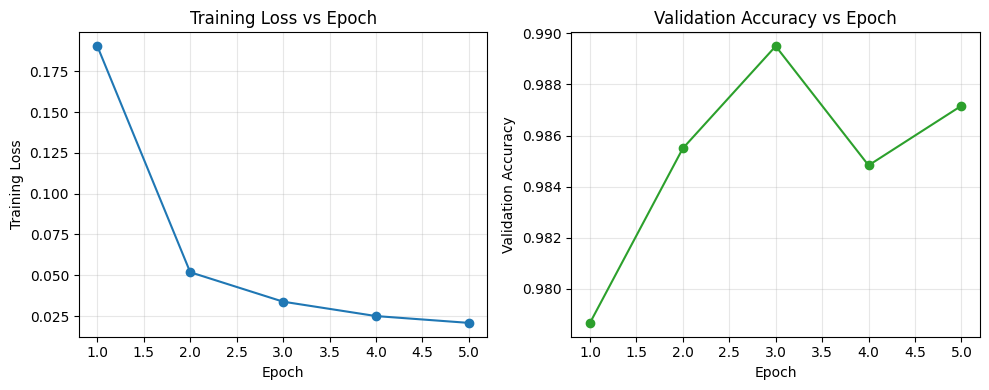

Training completed!


In [4]:
# Create a new CNN model (without the print statements for cleaner training)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.linear2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu3(x)
        x = self.linear2(x)
        return x


# Instantiate the model
model = SimpleCNN().to(device)

# Instantiate loss function
loss_fn = nn.CrossEntropyLoss()

# Create a new Adam optimizer for the CNN's parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Reuse the training function from Notebook 2
def train(dataloader, model, loss_fn, optimizer, epochs=5, val_dataloader=None):
    """
    Train the model for a specified number of epochs.
    Args:
        dataloader: DataLoader providing batches of training data
        model: The neural network model
        loss_fn: Loss function
        optimizer: Optimizer for updating weights
        epochs: Number of training epochs
        val_dataloader: Optional DataLoader for validation data
    """
    model.train()  # Set model to training mode
    epoch_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0
        
        for batch_idx, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            # Step 1: Forward pass
            pred = model(X)
            
            # Step 2: Calculate loss
            loss = loss_fn(pred, y)
            
            # Step 3: Backpropagation
            loss.backward()
            
            # Step 4: Update weights
            optimizer.step()
            
            # Step 5: Zero gradients
            optimizer.zero_grad()
            total_loss += loss.item()
            num_batches += 1
            
            # Print progress every 100 batches
            if (batch_idx + 1) % 100 == 0:
                avg_loss = total_loss / num_batches
                print(f"Epoch {epoch + 1}/{epochs}, Batch {batch_idx + 1}/{len(dataloader)}, Loss: {avg_loss:.4f}")
                
        # Print average loss for the epoch
        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs} completed. Average Loss: {avg_loss:.4f}")
        
        # Validation accuracy (optional)
        if val_dataloader is not None:
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for X, y in val_dataloader:
                    X, y = X.to(device), y.to(device)
                    logits = model(X)
                    preds = logits.argmax(dim=1)
                    correct += (preds == y).sum().item()
                    total += y.size(0)
            val_acc = correct / total
            val_accuracies.append(val_acc)
            print(f"Validation accuracy: {val_acc * 100:.2f}%")
            model.train()
        print()
        
    # Plot training loss vs epochs and validation accuracy
    epochs_range = range(1, epochs + 1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(epochs_range, epoch_losses, marker="o")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Training Loss")
    axes[0].set_title("Training Loss vs Epoch")
    axes[0].grid(True, alpha=0.3)
    if val_accuracies:
        axes[1].plot(epochs_range, val_accuracies, marker="o", color="tab:green")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Validation Accuracy")
        axes[1].set_title("Validation Accuracy vs Epoch")
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].axis("off")
        axes[1].text(0.5, 0.5, "No validation data provided", ha="center", va="center")
    plt.tight_layout()
    plt.show()
    return epoch_losses, val_accuracies


# Train the CNN
print("Starting CNN training...")
train(train_dataloader, model, loss_fn, optimizer, epochs=5, val_dataloader=val_dataloader)
print("Training completed!")

In [5]:
# Evaluate on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

accuracy = correct / total
print(f"Test accuracy: {accuracy * 100:.2f}%")


Test accuracy: 98.91%


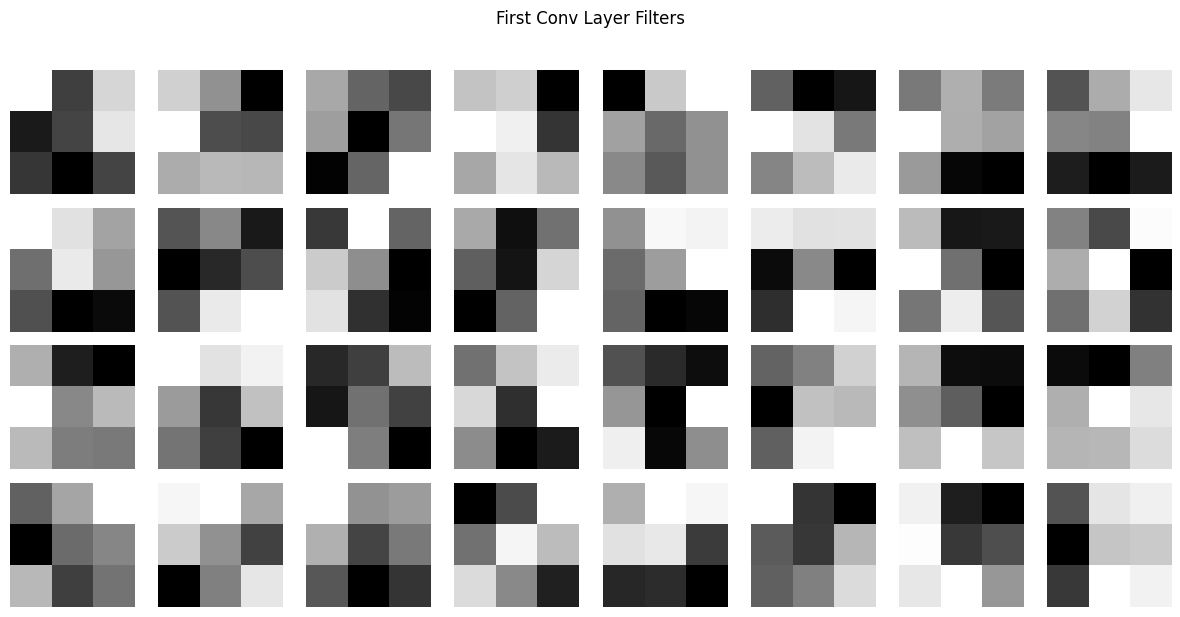

In [6]:
# Visualize learned filters from the first convolutional layer
weights = model.conv1.weight.detach().cpu()
num_filters = weights.shape[0]
cols = 8
rows = (num_filters + cols - 1) // cols

plt.figure(figsize=(cols * 1.5, rows * 1.5))
for i in range(num_filters):
    w = weights[i, 0]
    # Normalize per-filter for better contrast
    w_min, w_max = w.min(), w.max()
    if w_max > w_min:
        w = (w - w_min) / (w_max - w_min)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(w, cmap="gray")
    plt.axis("off")

plt.suptitle("First Conv Layer Filters", y=1.02)
plt.tight_layout()
plt.show()
